In [ ]:
# This is the basic proportional rate diffusion model from Palmer, Huk and Shadlen '05. 
# However, rather than fitting all 20 CD combinations at once, I fit 
# - all coherences at each distance
# - all distances at each coherence

# I fit all parameters for each parametric condition
# After the first step of finding likelihoods for every A, k, tR and x combination,
# I organize the A, k, tRs by k.
# Then, for each A, tR combination, I find the best k.
# Finally, I find the best A, tR, k combination.
# I then find better estimates of A, k and tR.

# In this version I am including all coherences but only distances of 0, ID (intermediate) and 45.
# This is in response to a reviewer saying that the presence of 3 distances that evoke similar
# behavior biases the model in favour of distance. 

# I am imposing the constraint that all parameters be positive.

In [1]:
## These are the pre-modelling steps where behavioral data is extracted from files.

# Load all required libraries
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import factorial as fact
# List subjects to fit
subs = ['Sub01', 'Sub02', 'Sub04', 'Sub05', 'Sub06', 'Sub08', 'Sub10', 'Sub11', 'Sub13']
nSub = len(subs)

# Define number of coherences per distance
nC = 4
# Define number of distances per coherence
nD = 4

# Initialize arrays to hold PC, mean and SD of RT, and # trials 
# for each coherence-distanct combination
# These values are obtained from the .csv files
pCs = np.zeros((nC*nD, nSub))
mRTs = np.zeros((nC*nD, nSub))
sdRTs = np.zeros((nC*nD, nSub))
Ns = np.zeros((nC*nD, nSub))

# Initialise a variable to hold # correct trials
# This will be computed from Ns and pCs
Rs = np.zeros((nC*nD, nSub))

# Extract behavioral data (PC, mean and SD of RT, # trials) from csv files
for si in range(nSub):
    csvFile = '../Data/Behavior/' + subs[si] + '_behavData.csv'
    behavData = pd.read_csv(csvFile, header=None)
    
    # Split the file in PC, mean RT and SD RT
    # Flatten each subject's values for ease of programming
    temp = np.array(behavData[0:4])
    pCs[:,si] = temp[:,0:4].flatten()
    temp = np.array(behavData[4:8])
    mRTs[:,si] = temp[:,0:4].flatten()
    temp = np.array(behavData[8:12])
    sdRTs[:,si] = temp[:,0:4].flatten()
    temp = np.array(behavData[12:])
    Ns[:,si] = temp[:,0:4].flatten()
    Rs[:,si] = np.round(Ns[:,si] * pCs[:,si])

In [5]:
print(mRTs[:,1])

[ 2.1398   2.0222   2.0511   2.0417   2.0315   1.9819   1.8577   1.8576
  1.8596   1.8778   1.6027   1.6017   1.4689   1.3855   1.0293   0.96204]


In [ ]:
# Parameters to fit:
# A: Boundary
# x: Stimulus strength
# k: Proportionality constant (Stim. str. = kx)
# tR: Residual time

# Equations to fit for each stimulus strength:
# pC = 1 / (1+exp(-2*A*k*abs(x)))
# mRT = A / (k*x) * tanh(A*k*x) + tR

# We can get approximate values for A, k and tR from Palmer et. al. '05
# Ranges of parameters to start with:
# A: 0.5 - 1
# k: 5 - 40
# tR: 0.25 - 0.5 (in seconds)
# x: 0 - 1

# To identify best fit, calculate the likelihood of predicted pC and mRT and find the maximum likelihood.

# Likelihood of pC follows a binomial distribution
# Lp = n! / (r!(n-r)! * pC(x)^r * (1-pC(x))^(n-r), where
# n = # trials, r = # required correct

# Likelihood of mRT follows a Gaussian distribution
# Lrt = 1 / (SDrt * (sqrt(2*pi))) * e^-((mRT(x) - oRT(x)) / SDrt)^2 * 1/2, where
# oRT = observed mRT, mRT = predicted mRT, SDrt = SD of predicted mRT

# VARrt = VARtd + VARtr, where
# VARtd = variance in decision time, VARtr = variance in residual time. Thus,
# VARrt = (A * tanh(A*k*x) - A*k*x * sech(A*k*x)) / (k*x)^3 + (0.1 * tR)^2

# Final fit measure is the log likelihood, which is the sum of the likelihoods of accuracy and mean RT, 
# over all combinations of coherence and distance
# Lprt = sigma(x)(ln(Lp(s)) + ln(Lrt(x)))

# The first pass of the model will be to estimate values of x without any assumptions about stimulus relationtips.
# The stopping point will be the point of least error.

In [2]:
## First run of the model. Stage 1:

Amin = 0.5
kmin = 0.001
tRmin = 0

# Initialize A, k and tR parameters
A_coh, dA_coh = np.linspace(Amin, 5, 10, retstep=True)
k_coh, dk_coh = np.linspace(kmin, 3, 10, retstep=True)
tR_coh, dtR_coh = np.linspace(tRmin, 2, 10, retstep=True)

A_dist, dA_dist = np.linspace(Amin, 5, 10, retstep=True)
k_dist, dk_dist = np.linspace(kmin, 3, 10, retstep=True)
tR_dist, dtR_dist = np.linspace(tRmin, 2, 10, retstep=True)


As_coh, tRs_coh, ks_coh = np.meshgrid(A_coh, tR_coh, k_coh)
As_coh = As_coh.flatten()
tRs_coh = tRs_coh.flatten()
ks_coh = ks_coh.flatten()
As_dist, tRs_dist, ks_dist = np.meshgrid(A_dist, tR_dist, k_dist)
As_dist = As_dist.flatten()
tRs_dist = tRs_dist.flatten()
ks_dist = ks_dist.flatten()

# This is the overall number of permutations of A, k and tR being performed
nPar = len(As_coh)
nK = len(k_coh)

# Initialize stimulus strength parameter
dx = 0.02
x_coh = np.arange(0.01, 8, dx)
x_dist = np.arange(0.01, 5, dx)

In [ ]:
dA_coh

In [ ]:
print(x_coh.shape, x_dist.shape)

In [3]:
# Initialize arrays that hold predicted accuracies and RTs
epc_coh_hi_d = np.ones((nPar, len(x_coh), nC, nSub)) * -9
ert_coh_hi_d = np.ones((nPar, len(x_coh), nC, nSub)) * -9
sdrt_coh_hi_d = np.ones((nPar, len(x_coh), nC, nSub)) * -9
epc_dist_hi_c = np.ones((nPar, len(x_dist), nD, nSub)) * -9
ert_dist_hi_c = np.ones((nPar, len(x_dist), nD, nSub)) * -9
sdrt_dist_hi_c = np.ones((nPar, len(x_dist), nD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc_coh_hi_d = np.zeros((nPar, len(x_coh), nC, nSub))
lrt_coh_hi_d = np.zeros((nPar, len(x_coh), nC, nSub))
lpc_dist_hi_c = np.zeros((nPar, len(x_dist), nD, nSub))
lrt_dist_hi_c = np.zeros((nPar, len(x_dist), nD, nSub))

## Now find the set of xs for 
# - All coherences at high distance, and
# - All distances at high coherence

for pi in range(nPar):
    # Calculate expected accuracy for each coherence-distance combination
    epcs = 1 / (1 + np.exp(-2 * As_coh[pi] * ks_coh[pi] * abs(x_coh)))
    temp = np.repeat(epcs,  nC * nSub, axis=0)
    epc_coh_hi_d[pi,...] = np.reshape(temp, (len(epcs), nC, nSub))
    
    epcs = 1 / (1 + np.exp(-2 * As_dist[pi] * ks_dist[pi] * abs(x_dist)))
    temp = np.repeat(epcs,  nD * nSub, axis=0)
    epc_dist_hi_c[pi,...] = np.reshape(temp, (len(epcs), nD, nSub))
    
    # Calculate expected mean RT for each coherence-distance combination
    erts = As_coh[pi] / (ks_coh[pi] * x_coh) * np.tanh(As_coh[pi] * ks_coh[pi] * x_coh) + tRs_coh[pi] 
    temp = np.repeat(erts,  nC * nSub, axis=0)
    ert_coh_hi_d[pi,...] = np.reshape(temp, (len(erts), nC, nSub))
    
    erts = As_dist[pi] / (ks_dist[pi] * x_dist) * np.tanh(As_dist[pi] * ks_dist[pi] * x_dist) + tRs_dist[pi] 
    temp = np.repeat(erts,  nD * nSub, axis=0)
    ert_dist_hi_c[pi,...] = np.reshape(temp, (len(erts), nD, nSub))
    
    for si in range(nSub):
        # Find the likelihood that the estimates calculated above match the observed PC and RT
        # for all coherences at each distance
        di = nD - 1
        for ci in range(nC):
            # Calculate the likelihood of accuracy
            lpc_coh_hi_d[pi,:,ci,si] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * \
                                                         fact(Ns[ci*nD+di,si]-Rs[ci*nD+di,si])) * \
                                (epc_coh_hi_d[pi,:,ci,si] ** Rs[ci*nD+di,si]) * \
                                ((1 - epc_coh_hi_d[pi,:,ci,si]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))

            # Calculate the standard error of mean ert
            sdrt_coh_hi_d[pi,:,ci,si] = np.sqrt(((As_coh[pi] * np.tanh(As_coh[pi] * ks_coh[pi] * x_coh) - \
                    As_coh[pi] * ks_coh[pi] * x_coh * (1/np.cosh(np.square(As_coh[pi] * ks_coh[pi] * x_coh)))) / \
                    (ks_coh[pi] * x_coh) ** 3 + np.square(0.1 * tRs_coh[pi])) / Ns[ci*nD+di,si])
            # Calculate the likelihood of RT
            lrt_coh_hi_d[pi,:,ci,si] = 1 / (sdrt_coh_hi_d[pi,:,ci,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert_coh_hi_d[pi,:,ci,si] - mRTs[ci*nD+di,si]) / \
                                                          sdrt_coh_hi_d[pi,:,ci,si]))

        # Find the likelihood that the estimates calculated above match the observed PC and RT
        # for all distances at each coherence
        ci = nC - 1
        for di in range(nD):
            # Calculate the likelihood of this accuracy
            lpc_dist_hi_c[pi,:,di,si] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * \
                                                                fact(Ns[ci*nD+di,si]-Rs[ci*nD+di,si])) * \
                                (epc_dist_hi_c[pi,:,di,si] ** Rs[ci*nD+di,si]) * \
                                ((1 - epc_dist_hi_c[pi,:,di,si]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))

            # Calculate the standard error of mean ert
            sdrt_dist_hi_c[pi,:,di,si] = np.sqrt(((As_dist[pi] * np.tanh(As_dist[pi] * ks_dist[pi] * x_dist) - \
                    As_dist[pi] * ks_dist[pi] * x_dist * (1/np.cosh(np.square(As_dist[pi] * ks_dist[pi] * x_dist)))) / \
                    (ks_dist[pi] * x_dist) ** 3 + np.square(0.1 * tRs_dist[pi])) / Ns[ci*nD+di,si])
            # Calculate the likelihood of observing that RT
            lrt_dist_hi_c[pi,:,di,si] = 1 / (sdrt_dist_hi_c[pi,:,di,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert_dist_hi_c[pi,:,di,si] - mRTs[ci*nD+di,si]) / \
                                                          sdrt_dist_hi_c[pi,:,di,si]))

# Find the set of best x values for all coherence at each distance and vice versa.
# Then calculate the total log-likelihood for each parameter combination

bestXcd_coh_d = np.ones((nPar, nC, nSub), dtype = np.int) * -9
bestXcd_dist_c = np.ones((nPar, nD, nSub), dtype = np.int) * -9

ll_coh_d = np.zeros((nPar, nSub))
ll_dist_c = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        di = nD - 1
        bestXcd_coh_d[pi,:,si] = np.argmax(lpc_coh_hi_d[pi,:,:,si] * lrt_coh_hi_d[pi,:,:,si],0)
        for ci in range(nC):
            ll_coh_d[pi,si] += np.log(lpc_coh_hi_d[pi,bestXcd_coh_d[pi,ci,si],ci,si]) + \
                                  np.log(lrt_coh_hi_d[pi,bestXcd_coh_d[pi,ci,si],ci,si])

        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        ci = nC - 1
        bestXcd_dist_c[pi,:,si] = np.argmax(lpc_dist_hi_c[pi,:,:,si] * lrt_dist_hi_c[pi,:,:,si],0)
        for di in range(nD):
            ll_dist_c[pi,si] += np.log(lpc_dist_hi_c[pi,bestXcd_dist_c[pi,di,si],di,si]) + \
                                   np.log(lrt_dist_hi_c[pi,bestXcd_dist_c[pi,di,si],di,si])
                
# The next step is to maximize over k (i.e., every set of 10 nPars)
nK = len(k_coh)
k_coh_d = np.ones((int(nPar/nK), nD, nSub), dtype = int) * -9
k_dist_c = np.ones((int(nPar/nK), nC, nSub), dtype = int) * -9

totLL_coh_d = np.zeros((int(nPar/nK), nD, nSub))
totLL_dist_c = np.zeros((int(nPar/nK), nC, nSub))

for si in range(nSub):
    for pi in range(0, nPar, nK):
        di = nD - 1
        # Find the best k for each A-tR combination
        bestK = np.argmax(ll_coh_d[pi:pi+nK,si])
        k_coh_d[int(pi/nK),di,si] = bestK
        # And find the likelihood at that K for each A-tR combination
        totLL_coh_d[int(pi/nK),di,si] = ll_coh_d[pi+bestK,si]

        ci = nC - 1
        # Find the best k for each A-tR combination
        bestK = np.argmax(ll_dist_c[pi:pi+nK,si])
        k_dist_c[int(pi/nK),ci,si] = bestK
        # And find the likelihood at that K for each A-tR combination
        totLL_dist_c[int(pi/nK),ci,si] = ll_dist_c[pi+bestK,si]
        
# Find the parameters for which total log-likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId_coh_d = np.zeros((nD, nSub), dtype = np.int)
maxParId_dist_c = np.zeros((nC, nSub), dtype = np.int)

# Record the values of best fit x for each CD combination
bestx_coh_d = np.zeros((nC, nSub), dtype = np.int)
bestx_dist_c = np.zeros((nD, nSub), dtype = np.int)
bestk_coh_d = np.zeros((nD, nSub))
bestk_dist_c = np.zeros((nC, nSub))
for si in range(nSub):
    di = nD - 1
    ids = np.where(totLL_coh_d[:,di,si] == np.nanmax(totLL_coh_d[:,di,si]))[0]
    if len(ids) > 1:
        maxParId_coh_d[di,si] = ids[0]
    else:
        maxParId_coh_d[di,si] = ids
    bestx_coh_d[:,si] = bestXcd_coh_d[maxParId_coh_d[di,si]*nK+k_coh_d[maxParId_coh_d[di,si],di,si],:,si]
    bestk_coh_d[di,si] = k_coh[k_coh_d[maxParId_coh_d[di,si],di,si]]

    ci = nC - 1
    ids = np.where(totLL_dist_c[:,ci,si] == np.nanmax(totLL_dist_c[:,ci,si]))[0]
    if len(ids) > 1:
        maxParId_dist_c[ci,si] = ids[0]
    else:
        maxParId_dist_c[ci,si] = ids
    bestx_dist_c[:,si] = bestXcd_dist_c[maxParId_dist_c[ci,si]*nK+k_dist_c[maxParId_dist_c[ci,si],ci,si],:,si]
    bestk_dist_c[ci,si] = k_dist[k_dist_c[maxParId_dist_c[ci,si],ci,si]]

In [4]:
print(bestx_coh_d)
print(bestx_dist_c)

[[  2   7  12   3   6   6  11   6   8]
 [ 17  66  87  27 129  63 135 133  20]
 [ 49  93 175  81 178 115 202 207  18]
 [225 217 271 142 289 241 284 241 256]]
[[ 11  16   3   7   1  12   2   7   7]
 [ 92  88  44  46  22  33  23  27  21]
 [230 210 111 116  40 197  53 174 114]
 [239 234 136 142  41 241  71 241 128]]


In [5]:
print(x_coh[bestx_coh_d])
print(x_dist[bestx_dist_c])

[[ 0.05  0.15  0.25  0.07  0.13  0.13  0.23  0.13  0.17]
 [ 0.35  1.33  1.75  0.55  2.59  1.27  2.71  2.67  0.41]
 [ 0.99  1.87  3.51  1.63  3.57  2.31  4.05  4.15  0.37]
 [ 4.51  4.35  5.43  2.85  5.79  4.83  5.69  4.83  5.13]]
[[ 0.23  0.33  0.07  0.15  0.03  0.25  0.05  0.15  0.15]
 [ 1.85  1.77  0.89  0.93  0.45  0.67  0.47  0.55  0.43]
 [ 4.61  4.21  2.23  2.33  0.81  3.95  1.07  3.49  2.29]
 [ 4.79  4.69  2.73  2.85  0.83  4.83  1.43  4.83  2.57]]


In [6]:
# Initialize arrays that hold predicted accuracies and RTs
epc_coh_d = np.ones((nPar, nD-1, nC, nSub)) * -9
ert_coh_d = np.ones((nPar, nD-1, nC, nSub)) * -9
sdrt_coh_d = np.ones((nPar, nD-1, nC, nSub)) * -9
epc_dist_c = np.ones((nPar, nC-1, nD, nSub)) * -9
ert_dist_c = np.ones((nPar, nC-1, nD, nSub)) * -9
sdrt_dist_c = np.ones((nPar, nC-1, nD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc_coh_d = np.zeros((nPar, nD-1, nC, nSub))
lrt_coh_d = np.zeros((nPar, nD-1, nC, nSub))
lpc_dist_c = np.zeros((nPar, nC-1, nD, nSub))
lrt_dist_c = np.zeros((nPar, nC-1, nD, nSub))

In [7]:
## Now find the set of A, k, tR for 
# - All coherences at distances other than high distance, and
# - All distances at coherences other than high coherence

for pi in range(nPar):
    for si in range(nSub):
        # Find the likelihood that the estimates calculated above match the observed PC and RT
        # for all coherences at each distance
        for di in range(nD-1):
            # Calculate expected accuracy and RT 
            epc_coh_d[pi,di,:,si] = 1 / (1 + np.exp(-2 * As_coh[pi] * ks_coh[pi] * x_coh[bestx_coh_d[:,si]]))
            ert_coh_d[pi,di,:,si]= As_coh[pi] / (ks_coh[pi] * x_coh[bestx_coh_d[:,si]]) * np.tanh(As_coh[pi] * \
                                                            ks_coh[pi] * x_coh[bestx_coh_d[:,si]]) + tRs_coh[pi] 
            for ci in range(nC):    
                # Calculate the likelihood of accuracy
                lpc_coh_d[pi,di,ci,si] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * \
                                    fact(Ns[ci*nD+di,si] - Rs[ci*nD+di,si])) * (epc_coh_d[pi,di,ci,si] ** Rs[ci*nD+di,si]) * \
                                    ((1 - epc_coh_d[pi,di,ci,si]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))

                # Calculate the standard error of mean ert
                sdrt_coh_d[pi,di,ci,si] = np.sqrt(((As_coh[pi] * np.tanh(As_coh[pi] * ks_coh[pi] * \
                                                                         x_coh[bestx_coh_d[ci,si]]) - \
                                        As_coh[pi] * ks_coh[pi] * x_coh[bestx_coh_d[ci,si]] * \
                                        (1/np.cosh(np.square(As_coh[pi] * ks_coh[pi] * x_coh[bestx_coh_d[ci,si]])))) / \
                        (ks_coh[pi] * x_coh[bestx_coh_d[ci,si]]) ** 3 + np.square(0.1 * tRs_coh[pi])) / Ns[ci*nD+di,si])
                # Calculate the likelihood of RT
                lrt_coh_d[pi,di,ci,si] = 1 / (sdrt_coh_d[pi,di,ci,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_coh_d[pi,di,ci,si] - mRTs[ci*nD+di,si]) / \
                                                              sdrt_coh_d[pi,di,ci,si]))

        # Find the likelihood that the estimates calculated above match the observed PC and RT
        # for all distances at each coherence
        for ci in range(nC-1):
            # Calculate expected accuracy and RT 
            epc_dist_c[pi,ci,:,si] = 1 / (1 + np.exp(-2 * As_dist[pi] * ks_dist[pi] * x_dist[bestx_dist_c[:,si]]))
            ert_dist_c[pi,ci,:,si]= As_dist[pi] / (ks_dist[pi] * x_dist[bestx_dist_c[:,si]]) * np.tanh(As_dist[pi] * \
                                                                ks_dist[pi] * x_dist[bestx_dist_c[:,si]]) + tRs_dist[pi] 
            for di in range(nD):
                # Calculate the likelihood of this accuracy
                lpc_dist_c[pi,ci,di,si] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * \
                                                                    fact(Ns[ci*nD+di,si]-Rs[ci*nD+di,si])) * \
                                    (epc_dist_c[pi,ci,di,si] ** Rs[ci*nD+di,si]) * \
                                    ((1 - epc_dist_c[pi,ci,di,si]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))

                # Calculate the standard error of mean ert
                sdrt_dist_c[pi,ci,di,si] = np.sqrt(((As_dist[pi] * np.tanh(As_dist[pi] * ks_dist[pi] * \
                                                                           x_dist[bestx_dist_c[di,si]]) - \
                                            As_dist[pi] * ks_dist[pi] * x_dist[bestx_dist_c[di,si]] * \
                                        (1/np.cosh(np.square(As_dist[pi] * ks_dist[pi] * x_dist[bestx_dist_c[di,si]])))) / \
                        (ks_dist[pi] * x_dist[bestx_dist_c[di,si]]) ** 3 + np.square(0.1 * tRs_dist[pi])) / Ns[ci*nD+di,si])
                # Calculate the likelihood of observing that RT
                lrt_dist_c[pi,ci,di,si] = 1 / (sdrt_dist_c[pi,ci,di,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_dist_c[pi,ci,di,si] - mRTs[ci*nD+di,si]) / \
                                                              sdrt_dist_c[pi,ci,di,si]))

# Find the set of best x values for all coherence at each distance and vice versa.
# Then calculate the total log-likelihood for each parameter combination

ll_coh_d = np.zeros((nPar, nD-1, nSub))
ll_dist_c = np.zeros((nPar, nC-1, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        for di in range(nD-1):
            for ci in range(nC):
                ll_coh_d[pi,di,si] += np.log(lpc_coh_d[pi,di,ci,si]) + \
                                      np.log(lrt_coh_d[pi,di,ci,si])

        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        for ci in range(nC-1):
            for di in range(nD):
                ll_dist_c[pi,ci,si] += np.log(lpc_dist_c[pi,ci,di,si]) + \
                                       np.log(lrt_dist_c[pi,ci,di,si])
                
# The next step is to maximize over k (i.e., every set of 10 nPars)

for si in range(nSub):
    for pi in range(0, nPar, nK):
        for di in range(nD-1):
            # Find the best k for each A-tR combination
            bestK = np.argmax(ll_coh_d[pi:pi+nK,di,si])
            k_coh_d[int(pi/nK),di,si] = bestK
            # And find the likelihood at that K for each A-tR combination
            totLL_coh_d[int(pi/nK),di,si] = ll_coh_d[pi+bestK,di,si]

        for ci in range(nC-1):
            # Find the best k for each A-tR combination
            bestK = np.argmax(ll_dist_c[pi:pi+nK,ci,si])
            k_dist_c[int(pi/nK),ci,si] = bestK
            # And find the likelihood at that K for each A-tR combination
            totLL_dist_c[int(pi/nK),ci,si] = ll_dist_c[pi+bestK,ci,si]
        
# Find the parameters for which total log-likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
# And record the values of best fit x for each CD combination
for si in range(nSub):
    for di in range(nD-1):
        ids = np.where(totLL_coh_d[:,di,si] == np.nanmax(totLL_coh_d[:,di,si]))[0]
        if len(ids) > 1:
            maxParId_coh_d[di,si] = ids[0]
        else:
            maxParId_coh_d[di,si] = ids
        bestk_coh_d[di,si] = k_coh[k_coh_d[maxParId_coh_d[di,si],di,si]]

    for ci in range(nC-1):
        ids = np.where(totLL_dist_c[:,ci,si] == np.nanmax(totLL_dist_c[:,ci,si]))[0]
        if len(ids) > 1:
            maxParId_dist_c[ci,si] = ids[0]
        else:
            maxParId_dist_c[ci,si] = ids
        bestk_dist_c[ci,si] = k_dist[k_dist_c[maxParId_dist_c[ci,si],ci,si]]

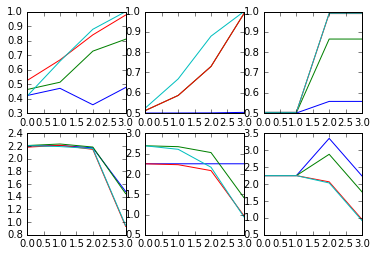

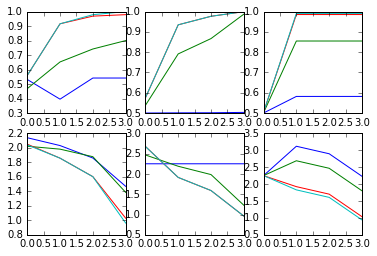

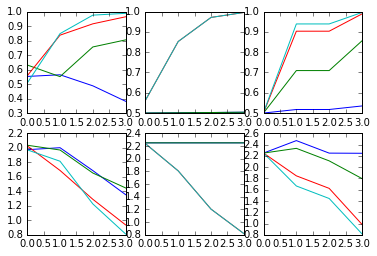

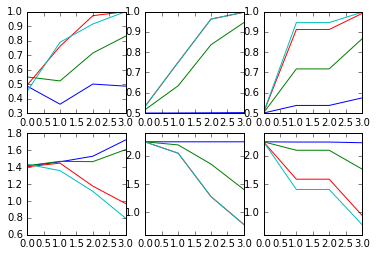

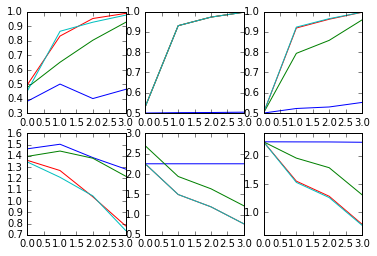

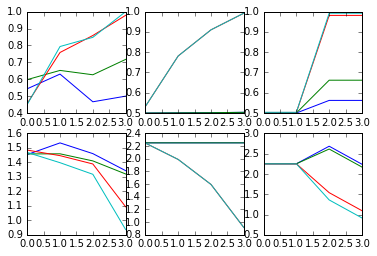

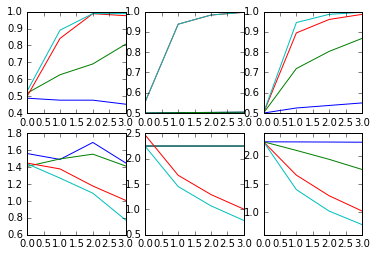

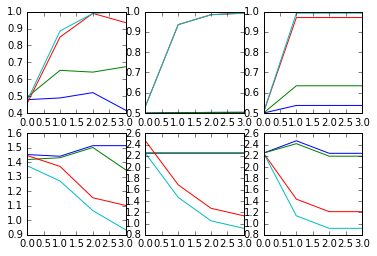

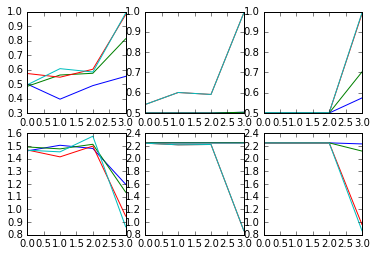

In [8]:
parId_c = np.zeros((nD, nSub), dtype = np.int)
parId_d = np.zeros((nC, nSub), dtype = np.int)
for si in range(nSub):
    pcFit_c = np.zeros((nC, nD))
    pcFit_d = np.zeros((nC, nD))
    rtFit_c = np.zeros((nC, nD))
    rtFit_d = np.zeros((nC, nD))
    
    for di in range(nD-1):
        parId_c[di,si] = maxParId_coh_d[di,si]*nK + k_coh_d[maxParId_coh_d[di,si],di,si]
        for ci in range(nC):
            pcFit_c[ci,di] = epc_coh_d[parId_c[di,si], di, ci, si]
            rtFit_c[ci,di] = ert_coh_d[parId_c[di,si], di, ci, si]
        
    di = nD - 1
    parId_c[di,si] = maxParId_coh_d[di,si]*nK+k_coh_d[maxParId_coh_d[di,si],di,si]
    for ci in range(nC):
        pcFit_c[ci,di] = epc_coh_hi_d[parId_c[di,si], bestx_coh_d[ci,si], ci, si]
        rtFit_c[ci,di] = ert_coh_hi_d[parId_c[di,si], bestx_coh_d[ci,si], ci, si]
        
    for ci in range(nC-1):
        parId_d[ci,si] = maxParId_dist_c[ci,si]*nK+k_dist_c[maxParId_dist_c[ci,si],ci,si]
        for di in range(nD):
            pcFit_d[ci,di] = epc_dist_c[parId_d[ci,si], ci, di, si]
            rtFit_d[ci,di] = ert_dist_c[parId_d[ci,si], ci, di, si]
        
    ci = nC - 1
    parId_d[ci,si] = maxParId_dist_c[ci,si]*nK+k_dist_c[maxParId_dist_c[ci,si],ci,si]
    for di in range(nD):
        pcFit_d[ci,di] = epc_dist_hi_c[parId_d[ci,si], bestx_dist_c[di,si], di, si]
        rtFit_d[ci,di] = ert_dist_hi_c[parId_d[ci,si], bestx_dist_c[di,si], di, si]
    
    plt.figure()
    plt.subplot(231)
    plt.plot(pCs[:,si].reshape((nC,nD)))
    plt.subplot(232)
    plt.plot(pcFit_c)
    plt.subplot(233)
    plt.plot(pcFit_d)
    
    plt.subplot(234)
    plt.plot(mRTs[:,si].reshape((nC,nD)))
    plt.subplot(235)
    plt.plot(rtFit_c)
    plt.subplot(236)
    plt.plot(rtFit_d)

In [9]:
parId_c

array([[ 20,  20,  20,  20,  20,  20,  20,  20,  20],
       [221, 121,  20,  21, 221,  20,  20,  20,  20],
       [ 21, 222,  21,  22,  21,  21, 121, 121,  21],
       [222, 222,  21,  22,  21,  21,  21,  21,  21]])

In [10]:
parId_d

array([[ 20,  20,  20,  20,  20,  20,  20,  20,  20],
       [ 20, 421, 121,  21,  23,  20,  22, 121,  20],
       [521, 321,  21,  21,  24, 221,  23,  21,  20],
       [ 21,  21,  22,  22,  27,  21,  24,  21,  22]])

In [11]:
print(As_coh[parId_c].round(decimals=2))
print(As_dist[parId_d].round(decimals=2))
print(tRs_coh[parId_c].round(decimals=2))
print(tRs_dist[parId_d].round(decimals=2))
print(ks_coh[parId_c].round(decimals=3))
print(ks_dist[parId_d].round(decimals=3))

[[ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]]
[[ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.44  0.22  0.    0.    0.44  0.    0.    0.    0.  ]
 [ 0.    0.44  0.    0.    0.    0.    0.22  0.22  0.  ]
 [ 0.44  0.44  0.    0.    0.    0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.89  0.22  0.    0.    0.    0.    0.22  0.  ]
 [ 1.11  0.67  0.    0.    0.    0.44  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
[[ 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001]
 [ 0.334  0.334  0.001  0.334  0.334  0.001  0.001  0.001  0.001]
 [ 0.334  0.667  0.334  

In [12]:
sumLL_c = np.zeros((40, nSub))
sumLL_d = np.zeros((40, nSub))
for si in range(nSub):
    temp_c = 0
    temp_d = 0
    for di in range(nD):
        temp_c += np.sum(totLL_coh_d[maxParId_coh_d[di,si],di,si]) 
    for ci in range(nC):
        temp_d += np.sum(totLL_dist_c[maxParId_dist_c[ci,si],ci,si])
    sumLL_c[0,si] = temp_c
    sumLL_d[0,si] = temp_d

In [13]:
print(sumLL_c[0,:].round(decimals=2))
print(sumLL_d[0,:].round(decimals=2))

[-103.22 -107.32 -109.42  -86.41 -140.26 -116.28 -104.26 -103.32 -114.34]
[-147.08 -111.14  -84.19  -90.81  -91.22 -166.29  -74.92  -98.87 -120.9 ]


In [14]:
# Run 2 of the model

minA_coh = np.zeros((nD, nSub))
maxA_coh = np.zeros((nD, nSub))
mink_coh = np.zeros((nD, nSub))
maxk_coh = np.zeros((nD, nSub))
mintR_coh = np.zeros((nD, nSub))
maxtR_coh = np.zeros((nD, nSub))

minA_dist = np.zeros((nC, nSub))
maxA_dist = np.zeros((nC, nSub))
mink_dist = np.zeros((nC, nSub))
maxk_dist = np.zeros((nC, nSub))
mintR_dist = np.zeros((nC, nSub))
maxtR_dist = np.zeros((nC, nSub))

nd = 3 # Number of deltas before and after best fit value

# Set up A, k and tR parameters for the next round of simulations
# Use the bestx values from the first run, don't fit for x again

# First set the range of all variables. 
# minVar = bestValue - dVar*nd : bestValue + dVar*nd
# If the new minimum is <= 0, then set it to the old minimum.
minA_coh = As_coh[parId_c] - nd * round(dA_coh, ndigits=3)
maxA_coh = As_coh[parId_c] + nd * round(dA_coh, ndigits=3)

mink_coh = ks_coh[parId_c] - nd * round(dk_coh, ndigits=3)
maxk_coh = ks_coh[parId_c] + nd * round(dk_coh, ndigits=3)

mintR_coh = tRs_coh[parId_c] - nd * round(dtR_coh, ndigits=3)
maxtR_coh = tRs_coh[parId_c] + nd * round(dtR_coh, ndigits=3)

minA_dist = As_dist[parId_d] - nd * round(dA_dist, ndigits=3)
maxA_dist = As_dist[parId_d] + nd * round(dA_dist, ndigits=3)

mink_dist = ks_dist[parId_d] - nd * round(dk_dist, ndigits=3)
maxk_dist = ks_dist[parId_d] + nd * round(dk_dist, ndigits=3)

mintR_dist = tRs_dist[parId_d] - nd * round(dtR_dist, ndigits=3)
maxtR_dist = tRs_dist[parId_d] + nd * round(dtR_dist, ndigits=3)

for si in range(nSub):
    minA_coh[minA_coh[:,si] < Amin,si] = Amin
    mink_coh[mink_coh[:,si] < kmin,si] = kmin
    mintR_coh[mintR_coh[:,si] < tRmin,si] = tRmin

    minA_dist[minA_dist[:,si] < Amin,si] = Amin
    mink_dist[mink_dist[:,si] < kmin,si] = kmin
    mintR_dist[mintR_dist[:,si] < tRmin,si] = tRmin

# Set up the parameter meshgrid
nStep = 9 # Number of values tested, per parameter

A_coh = np.zeros((nStep, nD, nSub))
dA_coh = np.zeros((nD, nSub))
k_coh = np.zeros((nStep, nD, nSub))
dk_coh = np.zeros((nD, nSub))
tR_coh = np.zeros((nStep, nD, nSub))
dtR_coh = np.zeros((nD, nSub))

A_dist = np.zeros((nStep, nC, nSub))
dA_dist = np.zeros((nC, nSub))
k_dist = np.zeros((nStep, nC, nSub))
dk_dist = np.zeros((nC, nSub))
tR_dist = np.zeros((nStep, nC, nSub))
dtR_dist = np.zeros((nC, nSub))

# This is the overall number of permutations of A, k and tR being performed
nPar = nStep ** 3

As_coh = np.zeros((nPar, nD, nSub))
ks_coh = np.zeros((nPar, nD, nSub))
tRs_coh = np.zeros((nPar, nD, nSub))

As_dist = np.zeros((nPar, nC, nSub))
ks_dist = np.zeros((nPar, nC, nSub))
tRs_dist = np.zeros((nPar, nC, nSub))

for si in range(nSub):
    for di in range(nD):
        A_coh[:,di,si], dA_coh[di,si] = np.linspace(minA_coh[di,si], maxA_coh[di,si], nStep, retstep=True)
        k_coh[:,di,si], dk_coh[di,si] = np.linspace(mink_coh[di,si], maxk_coh[di,si], nStep, retstep=True)
        tR_coh[:,di,si], dtR_coh[di,si] = np.linspace(mintR_coh[di,si], maxtR_coh[di,si], nStep, retstep=True)

        tempAs, temptRs, tempks = np.meshgrid(A_coh[:,di,si], tR_coh[:,di,si], k_coh[:,di,si])
        As_coh[:,di,si] = tempAs.flatten()
        ks_coh[:,di,si] = tempks.flatten()
        tRs_coh[:,di,si] = temptRs.flatten()

    for ci in range(nC):
        A_dist[:,ci,si], dA_dist[ci,si] = np.linspace(minA_dist[ci,si], maxA_dist[ci,si], nStep, retstep=True)
        k_dist[:,ci,si], dk_dist[ci,si] = np.linspace(mink_dist[ci,si], maxk_dist[ci,si], nStep, retstep=True)
        tR_dist[:,ci,si], dtR_dist[ci,si] = np.linspace(mintR_dist[ci,si], maxtR_dist[ci,si], nStep, retstep=True)

        tempAs, temptRs, tempks = np.meshgrid(A_dist[:,ci,si], tR_dist[:,ci,si], k_dist[:,ci,si])
        As_dist[:,ci,si] = tempAs.flatten()
        ks_dist[:,ci,si] = tempks.flatten()
        tRs_dist[:,ci,si] = temptRs.flatten()
    
# Initialize arrays that hold predicted accuracies and RTs
epc_coh_d = np.ones((nPar, nD, nC, nSub)) * -9
ert_coh_d = np.ones((nPar, nD, nC, nSub)) * -9
sdrt_coh_d = np.ones((nPar, nD, nC, nSub)) * -9
epc_dist_c = np.ones((nPar, nC, nD, nSub)) * -9
ert_dist_c = np.ones((nPar, nC, nD, nSub)) * -9
sdrt_dist_c = np.ones((nPar, nC, nD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc_coh_d = np.zeros((nPar, nD, nC, nSub))
lrt_coh_d = np.zeros((nPar, nD, nC, nSub))
lpc_dist_c = np.zeros((nPar, nC, nD, nSub))
lrt_dist_c = np.zeros((nPar, nC, nD, nSub))

In [15]:
## Now find the set of A, tR and k for 
# - All coherences at all but high distance, and
# - All distances at all but high coherence

for pi in range(nPar):
    for si in range(nSub):
        for di in range(nD):
            # Calculate expected accuracy and RT for all coherences at each distance 
            epc_coh_d[pi,di,:,si] = 1 / (1 + np.exp(-2 * As_coh[pi,di,si] * ks_coh[pi,di,si] * \
                                                    abs(x_coh[bestx_coh_d[:,si]])))
            ert_coh_d[pi,di,:,si] = As_coh[pi,di,si] / (ks_coh[pi,di,si] * x_coh[bestx_coh_d[:,si]]) * \
                                    np.tanh(As_coh[pi,di,si] * ks_coh[pi,di,si] * x_coh[bestx_coh_d[:,si]]) + \
                                    tRs_coh[pi,di,si]

            for ci in range(nC):
                # Calculate likelihood of accuracy for all coherences at each distance
                lpc_coh_d[pi,di,ci,si] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * \
                                                                    fact(Ns[ci*nD+di,si]-Rs[ci*nD+di,si])) \
                                    * (epc_coh_d[pi,di,ci,si] ** Rs[ci*nD+di,si]) * \
                                    ((1 - epc_coh_d[pi,di,ci,si]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))

                
                # Calculate SD of mean RT 
                sdrt_coh_d[pi,di,ci,si] = np.sqrt(((As_coh[pi,di,si] * np.tanh(As_coh[pi,di,si] * ks_coh[pi,di,si] * \
                                                     x_coh[bestx_coh_d[ci,si]]) - As_coh[pi,di,si] * \
                         ks_coh[pi,di,si] * x_coh[bestx_coh_d[ci,si]] * \
                        (1/np.cosh(np.square(As_coh[pi,di,si] * ks_coh[pi,di,si] * x_coh[bestx_coh_d[ci,si]])))) / \
                        (ks_coh[pi,di,si] * x_coh[bestx_coh_d[ci,si]]) ** 3 + \
                                                   np.square(0.1 * tRs_coh[pi,di,si])) / Ns[ci*nD+di,si])
                # Calculate likelihood of mean RT for all coherences at each distance
                lrt_coh_d[pi,di,ci,si] = 1 / (sdrt_coh_d[pi,di,ci,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_coh_d[pi,di,ci,si] - mRTs[ci*nD+di,si]) / \
                                                              sdrt_coh_d[pi,di,ci,si]))

        for ci in range(nC):
            # Calculate expected accuracy and RT for all distances at each coherence
            epc_dist_c[pi,ci,:,si] = 1 / (1 + np.exp(-2 * As_dist[pi,ci,si] * ks_dist[pi,ci,si] * \
                                                     abs(x_dist[bestx_dist_c[:,si]])))
            ert_dist_c[pi,ci,:,si] = As_dist[pi,ci,si] / (ks_dist[pi,ci,si] * x_dist[bestx_dist_c[:,si]]) * \
                                    np.tanh(As_dist[pi,ci,si] * ks_dist[pi,ci,si] * x_dist[bestx_dist_c[:,si]]) + \
                                    tRs_dist[pi,ci,si]

            for di in range(nD):
                # Calculate likelihood of accuracy for all distances at each coherence
                lpc_dist_c[pi,ci,di,si] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * \
                                                                    fact(Ns[ci*nD+di,si]-Rs[ci*nD+di,si])) \
                                    * (epc_dist_c[pi,ci,di,si] ** Rs[ci*nD+di,si]) * \
                                    ((1 - epc_dist_c[pi,ci,di,si]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))

                
                # Calculate SD of mean RT 
                sdrt_dist_c[pi,ci,di,si] = np.sqrt(((As_dist[pi,ci,si] * np.tanh(As_dist[pi,ci,si] * ks_dist[pi,ci,si] * \
                                                            x_dist[bestx_dist_c[di,si]]) - \
                        As_dist[pi,ci,si] * ks_dist[pi,ci,si] * x_dist[bestx_dist_c[di,si]] * \
                        (1/np.cosh(np.square(As_dist[pi,ci,si] * ks_dist[pi,ci,si] * x_dist[bestx_dist_c[di,si]])))) / \
                        (ks_dist[pi,ci,si] * x_dist[bestx_dist_c[di,si]]) ** 3 + \
                                                   np.square(0.1 * tRs_dist[pi,ci,si])) / Ns[ci*nD+di,si])
                # Calculate likelihood of mean RT for all distances at each coherence
                lrt_dist_c[pi,ci,di,si] = 1 / (sdrt_dist_c[pi,ci,di,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_dist_c[pi,ci,di,si] - mRTs[ci*nD+di,si]) / \
                                                              sdrt_dist_c[pi,ci,di,si]))
                
                
# Calculate the total log-likelihood for:
# all coherences at each distance
# all distances at each coherence
ll_coh_d = np.zeros((nPar, nD, nSub))
ll_dist_c = np.zeros((nPar, nC, nSub))

for si in range(nSub):
    for pi in range(nPar):
        for di in range(nD):
            ll_coh_d[pi,di,si] += np.sum(np.log(lpc_coh_d[pi,di,:,si])) + \
                                  np.sum(np.log(lrt_coh_d[pi,di,:,si]))
                    
        for ci in range(nC):
            ll_dist_c[pi,ci,si] += np.sum(np.log(lpc_dist_c[pi,ci,:,si])) + \
                                   np.sum(np.log(lrt_dist_c[pi,ci,:,si]))        
        
# For each A-tR combination, calculate best k value
k_coh_d = np.ones((int(nPar/nStep), nD, nSub), dtype = int) * -9
k_dist_c = np.ones((int(nPar/nStep), nC, nSub), dtype = int) * -9

totLL_coh_d = np.zeros((int(nPar/nStep), nD, nSub))
totLL_dist_c = np.zeros((int(nPar/nStep), nC, nSub))

for si in range(nSub):
    for pi in range(0, nPar, nStep):
        for di in range(nD):
            # Find the best k for each A-tR combination
            bestK = np.argmax(ll_coh_d[pi:pi+nStep,di,si])
            k_coh_d[int(pi/nStep),di,si] = bestK
            # And find the likelihood at that K for each A-tR combination
            totLL_coh_d[int(pi/nStep),di,si] = ll_coh_d[pi+bestK,di,si]
            
        for ci in range(nC):
            # Find the best k for each A-tR combination
            bestK = np.argmax(ll_dist_c[pi:pi+nStep,ci,si])
            k_dist_c[int(pi/nStep),ci,si] = bestK
            # And find the likelihood at that K for each A-tR combination
            totLL_dist_c[int(pi/nStep),ci,si] = ll_dist_c[pi+bestK,ci,si]

# Find the parameters for which total log-likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId_coh_d = np.zeros((nD, nSub), dtype = np.int)
maxParId_dist_c = np.zeros((nC, nSub), dtype = np.int)

# Record the values of best fit x for each CD combination
bestk_coh_d = np.zeros((nD, nSub))
bestk_dist_c = np.zeros((nC, nSub))
for si in range(nSub):
    for di in range(nD):
        ids = np.where(totLL_coh_d[:,di,si] == np.nanmax(totLL_coh_d[:,di,si]))[0]
        if len(ids) > 1:
            maxParId_coh_d[di,si] = ids[0]
        else:
            maxParId_coh_d[di,si] = ids
        bestk_coh_d[di,si] = k_coh[k_coh_d[maxParId_coh_d[di,si],di,si],di,si]
        
    for ci in range(nC):
        ids = np.where(totLL_dist_c[:,ci,si] == np.nanmax(totLL_dist_c[:,ci,si]))[0]
        if len(ids) > 1:
            maxParId_dist_c[ci,si] = ids[0]
        else:
            maxParId_dist_c[ci,si] = ids
        bestk_dist_c[ci,si] = k_dist[k_dist_c[maxParId_dist_c[ci,si],ci,si],ci,si]

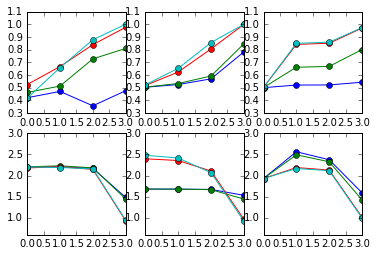

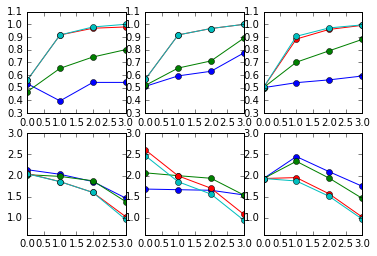

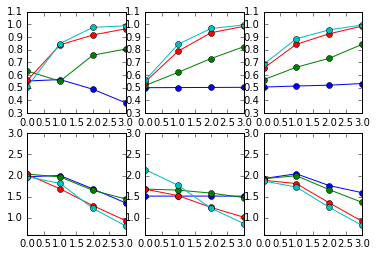

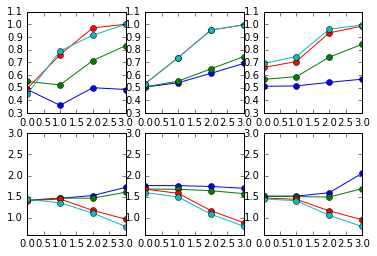

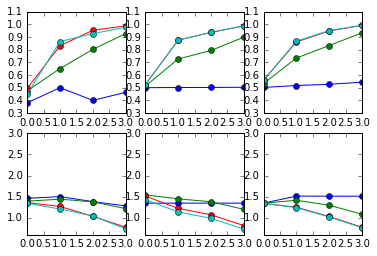

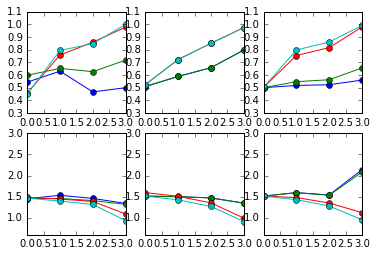

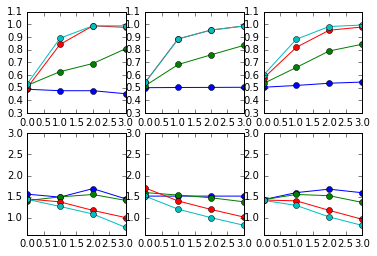

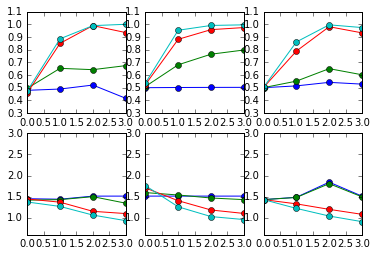

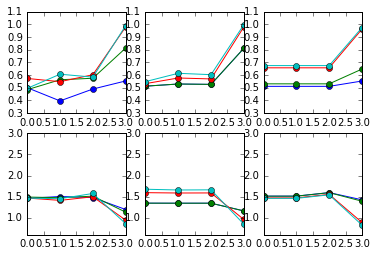

In [16]:
parId_c = np.zeros((nD, nSub), dtype = np.int)
parId_d = np.zeros((nC, nSub), dtype = np.int)
for si in range(nSub):
    pcFit_c = np.zeros((nC, nD))
    pcFit_d = np.zeros((nC, nD))
    rtFit_c = np.zeros((nC, nD))
    rtFit_d = np.zeros((nC, nD))
    
    for di in range(nD):
        parId_c[di,si] = (maxParId_coh_d[di,si]*nStep+k_coh_d[maxParId_coh_d[di,si],di,si])
        pcFit_c[:,di] = epc_coh_d[parId_c[di,si], di, :, si]
        rtFit_c[:,di] = ert_coh_d[parId_c[di,si], di, :, si]
        
    for ci in range(nC):
        parId_d[ci,si] = (maxParId_dist_c[ci,si]*nStep+k_dist_c[maxParId_dist_c[ci,si],ci,si])
        pcFit_d[ci,:] = epc_dist_c[parId_d[ci,si], ci, :, si]
        rtFit_d[ci,:] = ert_dist_c[parId_d[ci,si], ci, :, si]
        
    ymin = 0.3
    ymax = 1.1
    plt.figure()
    plt.subplot(231)
    plt.plot(pCs[:,si].reshape((nC,nD)), '-o')
    plt.ylim((ymin,ymax))
    plt.subplot(232)
    plt.plot(pcFit_c, '-o')
    plt.ylim((ymin,ymax))
    plt.subplot(233)
    plt.plot(pcFit_d, '-o')
    plt.ylim((ymin,ymax))
    
    ymin = 0.6
    ymax = 3
    plt.subplot(234)
    plt.plot(mRTs[:,si].reshape((nC,nD)), '-o')
    plt.ylim((ymin,ymax))
    plt.subplot(235)
    plt.plot(rtFit_c, '-o')
    plt.ylim((ymin,ymax))
    plt.subplot(236)
    plt.plot(rtFit_d, '-o')
    plt.ylim((ymin,ymax))

In [17]:
for si in range(nSub):
    temp_c = 0
    temp_d = 0
    for di in range(nD):
        temp_c += np.sum(totLL_coh_d[maxParId_coh_d[di,si],di,si]) 
    for ci in range(nC):
        temp_d += np.sum(totLL_dist_c[maxParId_dist_c[ci,si],ci,si])
    sumLL_c[1,si] = temp_c
    sumLL_d[1,si] = temp_d

In [18]:
print(sumLL_c[0:2,:].round(decimals=2))
print(sumLL_d[0:2,:].round(decimals=2))

[[-103.22 -107.32 -109.42  -86.41 -140.26 -116.28 -104.26 -103.32 -114.34]
 [ -61.95  -49.03  -53.77  -41.47  -43.85  -47.92  -43.05  -55.49  -46.3 ]]
[[-147.08 -111.14  -84.19  -90.81  -91.22 -166.29  -74.92  -98.87 -120.9 ]
 [ -71.25  -47.74  -40.14  -41.29  -34.99  -56.7   -30.2   -52.95  -57.08]]


In [19]:
# Save the values of the parameters and the likelihoods after the second run
pars_c = np.zeros((3, nD, nSub))
lls_c = np.zeros(nSub)
pars_d = np.zeros((3, nC, nSub))
lls_d = np.zeros(nSub)

for si in range(nSub):
    pars_c[0,:,si] = np.diag(As_coh[parId_c[:,si],:,si])
    pars_c[1,:,si] = np.diag(ks_coh[parId_c[:,si],:,si])
    pars_c[2,:,si] = np.diag(tRs_coh[parId_c[:,si],:,si])
    lls_c[si] = sumLL_c[1,si]
    
    pars_d[0,:,si] = np.diag(As_dist[parId_d[:,si],:,si])
    pars_d[1,:,si] = np.diag(ks_dist[parId_d[:,si],:,si])
    pars_d[2,:,si] = np.diag(tRs_dist[parId_d[:,si],:,si])
    lls_d[si] = sumLL_d[1,si]

In [20]:
# Run the simulation until it converges on a maximum likelihood, for parameteric coherences at each distance

run_c = np.ones(nSub, dtype = np.int) * 2
# Number of values generated per parameter, for each simulation run
nStep = 9
# Overall number of permutations of A, k and tR being performed
nPar = nStep ** 3

# Now we are going to maximize the likelihood for each subject separately.
for si in range(nSub):
    # Initialize the minimum and maximum values of the parameters
    minA = np.zeros(nD)
    maxA = np.zeros(nD)
    mink = np.zeros(nD)
    maxk = np.zeros(nD)
    mintR = np.zeros(nD)
    maxtR = np.zeros(nD)

    minA = np.diag(As_coh[parId_c[:,si],:,si].round(decimals=3)) - nd * dA_coh[:,si].round(decimals=3)
    maxA = np.diag(As_coh[parId_c[:,si],:,si].round(decimals=3)) + nd * dA_coh[:,si].round(decimals=3)

    mink = np.diag(ks_coh[parId_c[:,si],:,si].round(decimals=3)) - nd * dk_coh[:,si].round(decimals=3)
    maxk = np.diag(ks_coh[parId_c[:,si],:,si].round(decimals=3)) + nd * dk_coh[:,si].round(decimals=3)

    mintR = np.diag(tRs_coh[parId_c[:,si],:,si].round(decimals=3)) - nd * dtR_coh[:,si].round(decimals=3)
    maxtR = np.diag(tRs_coh[parId_c[:,si],:,si].round(decimals=3)) + nd * dtR_coh[:,si].round(decimals=3)

    # If any parameter is less than the minimum allowed value for that parameter, 
    # set it to the minimum allowed value
    minA[minA < Amin] = Amin
    mink[mink < kmin] = kmin
    mintR[mintR < tRmin] = tRmin

    A_run = []
    k_run = []
    tR_run = []
    
    # This variable keeps track of whether the simulation should continue or not
    simStop = 0

    while simStop == 0:
        if (maxA - minA).all() > 0.01 and (maxk - mink).all() > 0.001 and (maxtR - mintR).all() > 0.01:
            # Set up the parameter meshgrid
            A = np.zeros((nStep, nD))
            dA = np.zeros(nD)
            k = np.zeros((nStep, nD))
            dk = np.zeros(nD)
            tR = np.zeros((nStep, nD))
            dtR = np.zeros(nD)
            
            As = np.zeros((nPar, nD))
            ks = np.zeros((nPar, nD))
            tRs = np.zeros((nPar, nD))

            for di in range(nD):
                A[:,di], dA[di] = np.linspace(minA[di], maxA[di], nStep, retstep=True)
                k[:,di], dk[di] = np.linspace(mink[di], maxk[di], nStep, retstep=True)
                tR[:,di], dtR[di] = np.linspace(mintR[di], maxtR[di], nStep, retstep=True)

                tempAs, temptRs, tempks = np.meshgrid(A[:,di], tR[:,di], k[:,di])
                As[:,di] = tempAs.flatten()
                ks[:,di] = tempks.flatten()
                tRs[:,di] = temptRs.flatten()

            # Initialize arrays that hold predicted accuracies and RTs
            epc = np.ones((nPar, nD, nC)) * -9
            ert = np.ones((nPar, nD, nC)) * -9
            sdrt = np.ones((nPar, nD, nC)) * -9

            ## Initialize the array that holds the
            # individual likelihood values
            lpc = np.zeros((nPar, nD, nC))
            lrt = np.zeros((nPar, nD, nC))

            ## Now find the set of xs for 
            # - All coherences at high distance, and
            # - All distances at high coherence

            # Save the total log-likelihood for all coherences at each distance
            ll = np.zeros((nPar, nD))
            for pi in range(nPar):
                for di in range(nD):
                    # Calculate expected accuracy and RT for all coherences at each distance 
                    epc[pi,di,:] = 1 / (1 + np.exp(-2 * As[pi,di] * ks[pi,di] * abs(x_coh[bestx_coh_d[:,si]])))
                    ert[pi,di,:] = As[pi,di] / (ks[pi,di] * x_coh[bestx_coh_d[:,si]]) * \
                                            np.tanh(As[pi,di] * ks[pi,di] * x_coh[bestx_coh_d[:,si]]) + tRs[pi,di]

                    for ci in range(nC):
                        # Calculate likelihood of accuracy for all coherences at each distance
                        lpc[pi,di,ci] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * fact(Ns[ci*nD+di,si]-Rs[ci*nD+di,si])) \
                                            * (epc[pi,di,ci] ** Rs[ci*nD+di,si]) * \
                                            ((1 - epc[pi,di,ci]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))


                        # Calculate SD of mean RT 
                        sdrt[pi,di,ci] = np.sqrt(((As[pi,di] * np.tanh(As[pi,di] * ks[pi,di] * \
                                        x_coh[bestx_coh_d[ci,si]]) - As[pi,di] * ks[pi,di] * x_coh[bestx_coh_d[ci,si]] * \
                                (1/np.cosh(np.square(As[pi,di] * ks[pi,di] * x_coh[bestx_coh_d[ci,si]])))) / \
                                (ks[pi,di] * x_coh[bestx_coh_d[ci,si]]) ** 3 + np.square(0.1 * tRs[pi,di])) / Ns[ci*nD+di,si])
                        # Calculate likelihood of mean RT for all coherences at each distance
                        lrt[pi,di,ci] = 1 / (sdrt[pi,di,ci] * np.sqrt(2 * np.pi)) * \
                                            np.e ** (-1/2 * np.square((ert[pi,di,ci] - mRTs[ci*nD+di,si]) / sdrt[pi,di,ci]))

                    # Calculate the total log-likelihood for all coherences at each distance
                    ll[pi,di] += np.sum(np.log(lpc[pi,di,:])) + np.sum(np.log(lrt[pi,di,:]))

            # For each A-tR combination, calculate best k value
            k_id = np.ones((int(nPar/nStep), nD), dtype = int) * -9
            totLL = np.zeros((int(nPar/nStep), nD))

            for pi in range(0, nPar, nStep):
                for di in range(nD):
                    # Find the best k for each A-tR combination
                    bestK = np.argmax(ll[pi:pi+nStep,di])
                    k_id[int(pi/nStep),di] = bestK
                    # And find the likelihood at that K for each A-tR combination
                    totLL[int(pi/nStep),di] = ll[pi+bestK,di]

            # Find the parameters for which total log-likelihood is maximum
            # There are some NaN values in the likelihood matrix so exclude those
            maxParId = np.zeros(nD, dtype = np.int)

            # Record the values of best fit x for each CD combination
            bestk = np.zeros(nD)
            for di in range(nD):
                ids = np.where(totLL[:,di] == np.nanmax(totLL[:,di]))[0]
                if len(ids) == 0:
                    simStop = 1
                elif len(ids) > 1:
                    maxParId[di] = ids[0]
                else:
                    maxParId[di] = ids
                
            # Calculate total maximum loglikelihoods
            temp = 0
            for di in range(nD):
                temp += np.sum(totLL[maxParId[di],di]) 

            # Check to see if the simulation should continue for another run
            if simStop == 1 or \
            temp == sumLL_c[run_c[si]-2,si] or \
            (temp > sumLL_c[run_c[si]-1,si] and abs(sumLL_c[run_c[si]-1,si] - temp) <= 0.5) or \
            (temp < sumLL_c[run_c[si]-1,si] and abs(temp - sumLL_c[run_c[si]-1,si]) >= 15):
                simStop = 1
            else:
                sumLL_c[run_c[si],si] = temp
                run_c[si] += 1
                
                parId = maxParId * nStep + np.diag(k_id[maxParId,:])
                A_run.append(np.diag(As[parId,:]))
                k_run.append(np.diag(ks[parId,:]))
                tR_run.append(np.diag(tRs[parId,:]))

                # Re-initialize the minimum and maximum values of parameters for the next run
                minA = np.diag(As[parId,:].round(decimals=3)) - nd * dA.round(decimals=3)
                maxA = np.diag(As[parId,:].round(decimals=3)) + nd * dA.round(decimals=3)

                mink = np.diag(ks[parId,:].round(decimals=3)) - nd * dk.round(decimals=3)
                maxk = np.diag(ks[parId,:].round(decimals=3)) + nd * dk.round(decimals=3)

                mintR = np.diag(tRs[parId,:].round(decimals=3)) - nd * dtR.round(decimals=3)
                maxtR = np.diag(tRs[parId,:].round(decimals=3)) + nd * dtR.round(decimals=3)

                minA[minA < Amin] = Amin
                mink[mink < kmin] = kmin
                mintR[mintR < tRmin] = tRmin
        else:
            simStop = 1
    
    # Save the parameter values from the final simulation run
    if run_c[si] > 2:
        pars_c[0,:,si] = A_run[-1]
        pars_c[1,:,si] = k_run[-1]
        pars_c[2,:,si] = tR_run[-1]
        lls_c[si] = sumLL_c[run_c[si]-1,si]

In [21]:
run_c

array([4, 4, 4, 5, 3, 4, 4, 3, 4])

In [22]:
print(lls_c.round(decimals=2))

[-55.08 -36.8  -38.87 -35.18 -31.78 -35.9  -28.01 -35.34 -37.58]


In [23]:
np.sum(lls_c)

-334.54405072182072

In [24]:
# Run the simulation until it converges on a maximum likelihood, for parameteric distances at each coherence

run_d = np.ones(nSub, dtype = np.int) * 2
# Number of values generated per parameter, for each simulation run
nStep = 9
# Overall number of permutations of A, k and tR being performed
nPar = nStep ** 3

# Now we are going to maximize the likelihood for each subject separately.
for si in range(nSub):
    # Initialize the minimum and maximum values of the parameters
    minA = np.zeros(nC)
    maxA = np.zeros(nC)
    mink = np.zeros(nC)
    maxk = np.zeros(nC)
    mintR = np.zeros(nC)
    maxtR = np.zeros(nC)

    minA = np.diag(As_dist[parId_d[:,si],:,si].round(decimals=3)) - nd * dA_dist[:,si].round(decimals=3)
    maxA = np.diag(As_dist[parId_d[:,si],:,si].round(decimals=3)) + nd * dA_dist[:,si].round(decimals=3)

    mink = np.diag(ks_dist[parId_d[:,si],:,si].round(decimals=3)) - nd * dk_dist[:,si].round(decimals=3)
    maxk = np.diag(ks_dist[parId_d[:,si],:,si].round(decimals=3)) + nd * dk_dist[:,si].round(decimals=3)

    mintR = np.diag(tRs_dist[parId_d[:,si],:,si].round(decimals=3)) - nd * dtR_dist[:,si].round(decimals=3)
    maxtR = np.diag(tRs_dist[parId_d[:,si],:,si].round(decimals=3)) + nd * dtR_dist[:,si].round(decimals=3)

    # If any parameter is less than the minimum allowed value for that parameter, 
    # set it to the minimum allowed value
    minA[minA < Amin] = Amin
    mink[mink < kmin] = kmin
    mintR[mintR < tRmin] = tRmin

    # This variable keeps track of whether the simulation should continue or not
    simStop = 0

    A_run = []
    k_run = []
    tR_run = []
    
    while simStop == 0:
        if (maxA - minA).all() > 0.01 and (maxk - mink).all() > 0.001 and (maxtR - mintR).all() > 0.01:
            # Set up the parameter meshgrid
            A = np.zeros((nStep, nC))
            dA = np.zeros(nC)
            k = np.zeros((nStep, nC))
            dk = np.zeros(nC)
            tR = np.zeros((nStep, nC))
            dtR = np.zeros(nC)
            
            As = np.zeros((nPar, nC))
            ks = np.zeros((nPar, nC))
            tRs = np.zeros((nPar, nC))

            for ci in range(nC):
                A[:,ci], dA[ci] = np.linspace(minA[ci], maxA[ci], nStep, retstep=True)
                k[:,ci], dk[ci] = np.linspace(mink[ci], maxk[ci], nStep, retstep=True)
                tR[:,ci], dtR[ci] = np.linspace(mintR[ci], maxtR[ci], nStep, retstep=True)

                tempAs, temptRs, tempks = np.meshgrid(A[:,ci], tR[:,ci], k[:,ci])
                As[:,ci] = tempAs.flatten()
                ks[:,ci] = tempks.flatten()
                tRs[:,ci] = temptRs.flatten()

            # Initialize arrays that hold predicted accuracies and RTs
            epc = np.ones((nPar, nC, nD)) * -9
            ert = np.ones((nPar, nC, nD)) * -9
            sdrt = np.ones((nPar, nC, nD)) * -9

            ## Initialize the array that holds the
            # individual likelihood values
            lpc = np.zeros((nPar, nC, nD))
            lrt = np.zeros((nPar, nC, nD))

            ## Now find the set of xs for 
            # - All coherences at high distance, and
            # - All distances at high coherence

            # Save the total log-likelihood for all coherences at each distance
            ll = np.zeros((nPar, nC))
            for pi in range(nPar):
                for ci in range(nC):
                    # Calculate expected accuracy and RT for all coherences at each distance 
                    epc[pi,ci,:] = 1 / (1 + np.exp(-2 * As[pi,ci] * ks[pi,ci] * abs(x_dist[bestx_dist_c[:,si]])))
                    ert[pi,ci,:] = As[pi,ci] / (ks[pi,ci] * x_dist[bestx_dist_c[:,si]]) * \
                                            np.tanh(As[pi,ci] * ks[pi,ci] * x_dist[bestx_dist_c[:,si]]) + tRs[pi,ci]

                    for di in range(nD):
                        # Calculate likelihood of accuracy for all coherences at each distance
                        lpc[pi,ci,di] = fact(Ns[ci*nD+di,si]) / (fact(Rs[ci*nD+di,si]) * fact(Ns[ci*nD+di,si]-Rs[ci*nD+di,si])) \
                                            * (epc[pi,ci,di] ** Rs[ci*nD+di,si]) * \
                                            ((1 - epc[pi,ci,di]) ** (Ns[ci*nD+di,si] - Rs[ci*nD+di,si]))


                        # Calculate SD of mean RT 
                        sdrt[pi,ci,di] = np.sqrt(((As[pi,ci] * np.tanh(As[pi,ci] * ks[pi,ci] * \
                                        x_dist[bestx_dist_c[di,si]]) - As[pi,ci] * ks[pi,ci] * x_dist[bestx_dist_c[di,si]] \
                                * (1/np.cosh(np.square(As[pi,ci] * ks[pi,ci] * x_dist[bestx_dist_c[di,si]])))) / \
                                (ks[pi,ci] * x_dist[bestx_dist_c[di,si]]) ** 3 + np.square(0.1 * tRs[pi,ci])) / \
                                                 Ns[ci*nD+di,si])
                        # Calculate likelihood of mean RT for all coherences at each distance
                        lrt[pi,ci,di] = 1 / (sdrt[pi,ci,di] * np.sqrt(2 * np.pi)) * \
                                            np.e ** (-1/2 * np.square((ert[pi,ci,di] - mRTs[ci*nD+di,si]) / sdrt[pi,ci,di]))

                    # Calculate the total log-likelihood for all coherences at each distance
                    ll[pi,ci] += np.sum(np.log(lpc[pi,ci,:])) + np.sum(np.log(lrt[pi,ci,:]))

            # For each A-tR combination, calculate best k value
            k_id = np.ones((int(nPar/nStep), nC), dtype = int) * -9
            totLL = np.zeros((int(nPar/nStep), nC))

            for pi in range(0, nPar, nStep):
                for ci in range(nC):
                    # Find the best k for each A-tR combination
                    bestK = np.argmax(ll[pi:pi+nStep,ci])
                    k_id[int(pi/nStep),ci] = bestK
                    # And find the likelihood at that K for each A-tR combination
                    totLL[int(pi/nStep),ci] = ll[pi+bestK,ci]

            # Find the parameters for which total log-likelihood is maximum
            # There are some NaN values in the likelihood matrix so exclude those
            maxParId = np.zeros(nC, dtype = np.int)

            # Record the values of best fit x for each CD combination
            bestk = np.zeros(nC)
            for ci in range(nC):
                ids = np.where(totLL[:,ci] == np.nanmax(totLL[:,ci]))[0]
                if len(ids) == 0:
                    simStop = 1
                elif len(ids) > 1:
                    maxParId[ci] = ids[0]
                else:
                    maxParId[ci] = ids
                
            # Calculate total maximum loglikelihoods
            temp = 0
            for ci in range(nC):
                temp += np.sum(totLL[maxParId[ci],ci]) 

            # Check to see if the simulation should continue for another run
            if simStop == 1 or \
            temp == sumLL_d[run_d[si]-2,si] or \
            (temp > sumLL_d[run_d[si]-1,si] and abs(sumLL_d[run_d[si]-1,si] - temp) <= 0.5) or \
            (temp < sumLL_d[run_d[si]-1,si] and abs(temp - sumLL_d[run_d[si]-1,si]) >= 15):
                simStop = 1
            else:
                sumLL_d[run_d[si],si] = temp
                run_d[si] += 1
                
                parId = maxParId * nStep + np.diag(k_id[maxParId,:])
                A_run.append(np.diag(As[parId,:]))
                k_run.append(np.diag(ks[parId,:]))
                tR_run.append(np.diag(tRs[parId,:]))

                # Re-initialize the minimum and maximum values of parameters for the next run
                minA = np.diag(As[parId,:].round(decimals=3)) - nd * dA.round(decimals=3)
                maxA = np.diag(As[parId,:].round(decimals=3)) + nd * dA.round(decimals=3)

                mink = np.diag(ks[parId,:].round(decimals=3)) - nd * dk.round(decimals=3)
                maxk = np.diag(ks[parId,:].round(decimals=3)) + nd * dk.round(decimals=3)

                mintR = np.diag(tRs[parId,:].round(decimals=3)) - nd * dtR.round(decimals=3)
                maxtR = np.diag(tRs[parId,:].round(decimals=3)) + nd * dtR.round(decimals=3)

                minA[minA < Amin] = Amin
                mink[mink < kmin] = kmin
                mintR[mintR < tRmin] = tRmin
        else:
            simStop = 1
    
    # Save the parameter values from the final simulation run
    if run_d[si] > 2:
        pars_d[0,:,si] = A_run[-1]
        pars_d[1,:,si] = k_run[-1]
        pars_d[2,:,si] = tR_run[-1]
        lls_d[si] = sumLL_d[run_d[si]-1,si]

In [25]:
run_d

array([10,  5,  5,  5,  3,  5,  5,  4,  4])

In [26]:
print(lls_d.round(decimals=2))

[-30.5  -23.99 -33.32 -29.59 -31.97 -41.8  -26.3  -37.25 -48.99]


In [27]:
sum(lls_d)

-303.70579436812596

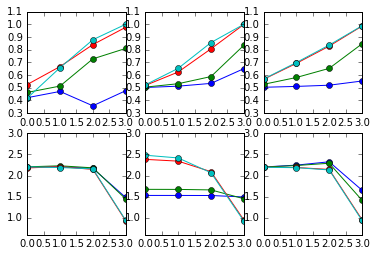

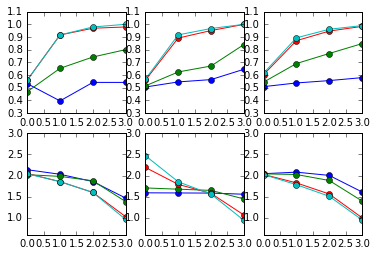

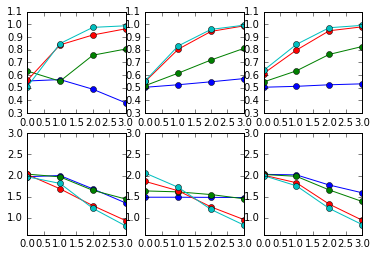

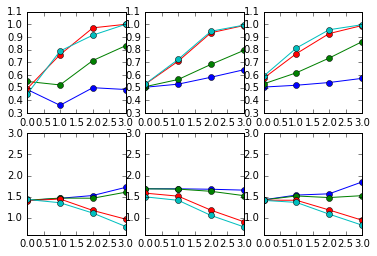

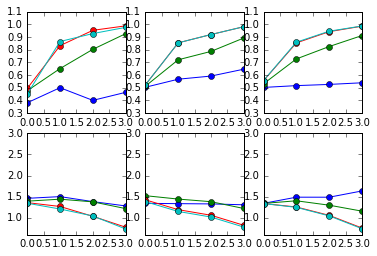

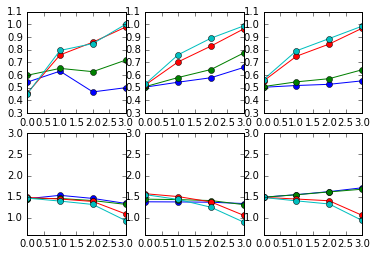

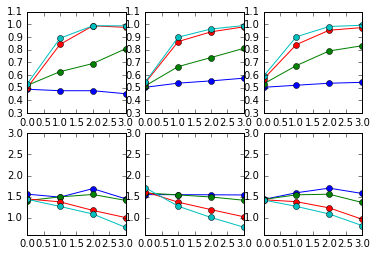

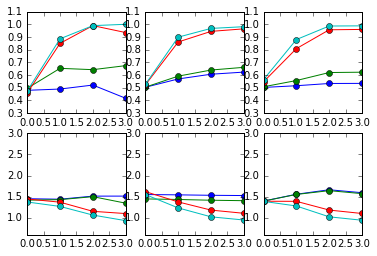

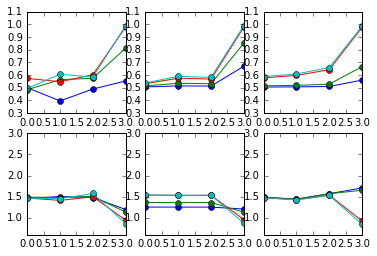

In [28]:
pcFit_c = np.zeros((nC, nD, nSub))
pcFit_d = np.zeros((nC, nD, nSub))
rtFit_c = np.zeros((nC, nD, nSub))
rtFit_d = np.zeros((nC, nD, nSub))
    
for si in range(nSub):
    for di in range(nD):
        pcFit_c[:,di,si] = 1 / (1 + np.exp(-2 * pars_c[0,di,si] * pars_c[1,di,si] * abs(x_coh[bestx_coh_d[:,si]])))
        rtFit_c[:,di,si] = pars_c[0,di,si] / (pars_c[1,di,si] * x_coh[bestx_coh_d[:,si]]) * \
                        np.tanh(pars_c[0,di,si] * pars_c[1,di,si] * x_coh[bestx_coh_d[:,si]]) + \
                        pars_c[2,di,si]
        
    for ci in range(nC):
        pcFit_d[ci,:,si] = 1 / (1 + np.exp(-2 * pars_d[0,ci,si] * pars_d[1,ci,si] * abs(x_dist[bestx_dist_c[:,si]])))
        rtFit_d[ci,:,si] = pars_d[0,ci,si] / (pars_d[1,ci,si] * x_dist[bestx_dist_c[:,si]]) * \
                        np.tanh(pars_d[0,ci,si] * pars_d[1,ci,si] * x_dist[bestx_dist_c[:,si]]) + \
                        pars_d[2,ci,si]
        
    ymin = 0.3
    ymax = 1.1
    plt.figure()
    plt.subplot(231)
    plt.plot(pCs[:,si].reshape((nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.subplot(232)
    plt.plot(pcFit_c[...,si],'o-')
    plt.ylim((ymin,ymax))
    plt.subplot(233)
    plt.plot(pcFit_d[...,si],'o-')
    plt.ylim((ymin,ymax))
    
    ymin = 0.6
    ymax = 3
    plt.subplot(234)
    plt.plot(mRTs[:,si].reshape((nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.subplot(235)
    plt.plot(rtFit_c[...,si],'o-')
    plt.ylim((ymin,ymax))
    plt.subplot(236)
    plt.plot(rtFit_d[...,si],'o-')
    plt.ylim((ymin,ymax))

In [29]:
# Final A values for parametric coherence at each distance
pars_c[0,:,:].T.round(decimals=2)

array([[ 1.08,  1.13,  1.44,  1.44],
       [ 1.08,  1.2 ,  1.26,  1.44],
       [ 1.08,  1.13,  1.28,  1.44],
       [ 1.08,  1.12,  1.08,  1.08],
       [ 1.09,  1.09,  1.09,  1.09],
       [ 1.08,  1.08,  1.08,  1.08],
       [ 1.08,  1.08,  1.08,  1.28],
       [ 1.09,  1.09,  1.09,  1.09],
       [ 1.08,  1.08,  1.08,  1.08]])

In [30]:
# Final A values for parametric distance at each coherence
pars_d[0,:,:].T.round(decimals=2)

array([[ 1.02,  1.05,  1.05,  1.14],
       [ 1.08,  1.07,  1.08,  1.08],
       [ 1.08,  1.19,  1.08,  1.13],
       [ 1.08,  1.08,  1.08,  1.26],
       [ 1.09,  1.09,  1.09,  1.28],
       [ 1.08,  1.08,  1.08,  1.2 ],
       [ 1.08,  1.08,  1.08,  1.13],
       [ 1.08,  1.08,  1.08,  1.08],
       [ 1.08,  1.08,  1.08,  1.28]])

In [31]:
# Final k values for parametric coherence at each distance
pars_c[1,:,:].T.round(decimals=2)

array([[ 0.06,  0.16,  0.5 ,  0.63],
       [ 0.06,  0.16,  0.63,  0.63],
       [ 0.02,  0.12,  0.31,  0.31],
       [ 0.09,  0.21,  0.75,  0.8 ],
       [ 0.05,  0.17,  0.31,  0.31],
       [ 0.06,  0.12,  0.31,  0.42],
       [ 0.02,  0.12,  0.31,  0.31],
       [ 0.05,  0.06,  0.31,  0.38],
       [ 0.06,  0.16,  0.34,  0.41]])

In [32]:
# Final k values for parametric distance at each coherence
pars_d[1,:,:].T.round(decimals=2)

array([[ 0.03,  0.08,  0.16,  0.4 ],
       [ 0.05,  0.21,  0.31,  0.45],
       [ 0.09,  0.26,  0.6 ,  0.77],
       [ 0.06,  0.24,  0.5 ,  0.78],
       [ 0.13,  1.  ,  1.58,  2.02],
       [ 0.02,  0.13,  0.2 ,  0.36],
       [ 0.12,  0.71,  1.3 ,  1.49],
       [ 0.02,  0.19,  0.41,  0.42],
       [ 0.06,  0.08,  0.12,  0.63]])

In [33]:
# Final tR values for parametric coherence at each distance
pars_c[2,:,:].T.round(decimals=2)

array([[ 0.35,  0.39,  0.32,  0.42],
       [ 0.42,  0.26,  0.61,  0.42],
       [ 0.31,  0.35,  0.23,  0.  ],
       [ 0.51,  0.43,  0.41,  0.32],
       [ 0.17,  0.35,  0.25,  0.21],
       [ 0.2 ,  0.27,  0.4 ,  0.37],
       [ 0.37,  0.41,  0.44,  0.08],
       [ 0.37,  0.27,  0.44,  0.38],
       [ 0.08,  0.19,  0.36,  0.37]])

In [34]:
# Final tR values for parametric distance at each coherence
pars_d[2,:,:].T.round(decimals=2)

array([[ 1.16,  1.15,  1.23,  0.37],
       [ 0.87,  0.93,  0.83,  0.45],
       [ 0.85,  0.59,  0.6 ,  0.31],
       [ 0.25,  0.36,  0.4 ,  0.27],
       [ 0.17,  0.31,  0.31,  0.  ],
       [ 0.31,  0.37,  0.45,  0.27],
       [ 0.26,  0.42,  0.53,  0.3 ],
       [ 0.22,  0.38,  0.49,  0.42],
       [ 0.31,  0.27,  0.4 ,  0.08]])

In [42]:
# Open a file to save model results 
# Save data from the Coherence model
filePrefix = '4distances_noD90'
fitFile = open('CoherenceModel_' + filePrefix, 'w')

# Write parameter ranges to file
fitFile.write('Final A values:\n')
fitFile.write(str(repr(pars_c[0,:,:].round(decimals=2))) + '\n')
fitFile.write('Final k values:\n')
fitFile.write(str(repr(pars_c[1,:,:].round(decimals=2))) + '\n')
fitFile.write('Final tR values:\n')
fitFile.write(str(repr(pars_c[2,:,:].round(decimals=2))) + '\n')
fitFile.write('Final log-likelihood values:\n')
fitFile.write(str(repr(lls_c.round(decimals=2))) + '\n')

fitFile.write('\nFinal PC values:\n')
for si in range(nSub):
    fitFile.write(subs[si] + ':\n')
    fitFile.write(str(repr(pcFit_c.round(decimals=2))) + '\n')
    
fitFile.write('\nFinal RT values:\n')
for si in range(nSub):
    fitFile.write(subs[si] + ':\n')
    fitFile.write(str(repr(rtFit_c.round(decimals=2))) + '\n')
    
fitFile.close()

# Save data from the Distance model
fitFile = open('DistanceModel_' + filePrefix, 'w')

# Write parameter ranges to file
fitFile.write('Final A values:\n')
fitFile.write(str(repr(pars_d[0,:,:].round(decimals=2))) + '\n')
fitFile.write('Final k values:\n')
fitFile.write(str(repr(pars_d[1,:,:].round(decimals=2))) + '\n')
fitFile.write('Final tR values:\n')
fitFile.write(str(repr(pars_d[2,:,:].round(decimals=2))) + '\n')
fitFile.write('Final log-likelihood values:\n')
fitFile.write(str(repr(lls_d.round(decimals=2))) + '\n')

fitFile.write('\nFinal PC values:\n')
for si in range(nSub):
    fitFile.write(subs[si] + ':\n')
    fitFile.write(str(repr(pcFit_d.round(decimals=2))) + '\n')
    
fitFile.write('\nFinal RT values:\n')
for si in range(nSub):
    fitFile.write(subs[si] + ':\n')
    fitFile.write(str(repr(rtFit_d.round(decimals=2))) + '\n')
    
fitFile.close()

(0.6, 3)

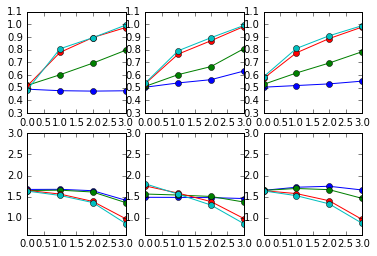

In [37]:
# Plot average curves

# Load average behavior
csvFile = '../Data/Behavior/All_behavData.csv'
behavData = pd.read_csv(csvFile, header=None)
    
# Split the file in PC, mean RT and SD RT
# Flatten each subject's values for ease of programming
temp = np.array(behavData[0:4])
pCs = temp[:,[0,1,2,3]]
temp = np.array(behavData[4:8])
mRTs = temp[:,[0,1,2,3]]
temp = np.array(behavData[8:12])
sdRTs = temp[:,[0,1,2,3]]
    
# Get mean and SD values for fits of coherence model
pcm_coh = np.mean(pcFit_c, axis=2)
pcsd_coh = np.std(pcFit_c, axis=2)

rtm_coh = np.mean(rtFit_c, axis=2)
rtsd_coh = np.std(rtFit_c, axis=2)

# Get mean and SD values for fits of distance model
pcm_dist = np.mean(pcFit_d, axis=2)
pcsd_dist = np.std(pcFit_d, axis=2)

rtm_dist = np.mean(rtFit_d, axis=2)
rtsd_dist = np.std(rtFit_d, axis=2)

# Plot the figures
ymin = 0.3
ymax = 1.1
plt.figure()
plt.subplot(231)
plt.plot(pCs,'o-')
plt.ylim((ymin,ymax))
plt.subplot(232)
plt.plot(pcm_coh,'o-')
plt.ylim((ymin,ymax))
plt.subplot(233)
plt.plot(pcm_dist,'o-')
plt.ylim((ymin,ymax))

ymin = 0.6
ymax = 3
plt.subplot(234)
plt.plot(mRTs,'o-')
plt.ylim((ymin,ymax))
plt.subplot(235)
plt.plot(rtm_coh,'o-')
plt.ylim((ymin,ymax))
plt.subplot(236)
plt.plot(rtm_dist,'o-')
plt.ylim((ymin,ymax))

In [38]:
pcm_coh

array([[ 0.50376225,  0.51082531,  0.53246705,  0.53756499],
       [ 0.53756484,  0.60300707,  0.76486029,  0.79129532],
       [ 0.56326902,  0.66650144,  0.87049261,  0.89428834],
       [ 0.63122948,  0.80733511,  0.9824226 ,  0.99044847]])

In [39]:
rtm_coh

array([[ 1.48736768,  1.56434608,  1.7560337 ,  1.80594469],
       [ 1.48456501,  1.54099382,  1.58588373,  1.5607625 ],
       [ 1.47981874,  1.50685359,  1.38537319,  1.30338274],
       [ 1.45793477,  1.37529555,  0.98545607,  0.86383382]])

In [40]:
pcm_dist

array([[ 0.50395458,  0.52634032,  0.57273407,  0.58566856],
       [ 0.51688556,  0.61580295,  0.77464552,  0.80927285],
       [ 0.52994621,  0.694452  ,  0.88745479,  0.9096338 ],
       [ 0.55159683,  0.78341276,  0.97786276,  0.98893409]])

In [41]:
rtm_dist

array([[ 1.65131983,  1.65000971,  1.64236787,  1.638824  ],
       [ 1.72488231,  1.69574306,  1.5753265 ,  1.52551689],
       [ 1.7479951 ,  1.66786542,  1.40560746,  1.33174316],
       [ 1.66070891,  1.46283853,  0.96438623,  0.87361792]])